# ABCD Method for estimating the Z-QCD correction factors.

In [33]:
import os
from scipy.optimize import curve_fit
import ROOT
from ROOT import gStyle
import ctypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def biner(edges,bin_widths,histogram):
    if (len(edges)+1!=len(bin_widths)):
        print("Check edges and bin widths array sizes!")
        return
    
    bins=[]
    first_bin = histogram.GetXaxis().GetBinLowEdge(1)
    #print(first_bin)
    last_bin = histogram.GetXaxis().GetBinUpEdge(histogram.GetNbinsX())
    #print(last_bin)
    for i in range(0,len(edges)):
        n_spaces = int((edges[i] - first_bin)/bin_widths[i])
        bins = np.concatenate((bins,np.linspace(first_bin,edges[i],n_spaces,endpoint=False)))
        first_bin = edges[i]
        if edges[i]==edges[-1]:
            n_spaces = int((last_bin - edges[i])/bin_widths[i+1])
            bins = np.concatenate((bins,np.linspace(edges[i],last_bin,n_spaces,endpoint=False)))
            bins = np.concatenate((bins,[last_bin]))
    return bins

def normalization(hist_list,norm_bin):
    for hist in hist_list:
        for i in range(1,hist.GetNbinsX()+1):
            value=hist.GetBinContent(i)
            error=hist.GetBinError(i)
            sf=hist.GetBinWidth(i)/norm_bin
            hist.SetBinContent(i,value/sf)
            hist.SetBinError(i,error/sf)
            
def ratio_subtracted_plot(path_to_samples=os.getcwd(),signal_name="Signal",data_name="Data",bg_names=[],histogram_info=None):
    
    MC = ROOT.TFile.Open(path_to_samples+"/"+"MC"+".root","READ")
    Data = ROOT.TFile.Open(path_to_samples+"/"+data_name+".root","READ")
    Signal = ROOT.TFile.Open(path_to_samples+"/"+signal_name+".root","READ")
    
    bg_files_list=[]
    for i in bg_names:
        bg_files_list.append(ROOT.TFile.Open(path_to_samples+"/"+i+".root","READ"))
    
    histogram_name = list(histogram_info.keys())[0]

    mc=MC.Get(histogram_name)
    data=Data.Get(histogram_name)
    signal=Signal.Get(histogram_name)
    
    bg_histograms_list = [i.Get(histogram_name) for i in bg_files_list]
    
    
    mc.SetDirectory(0)
    signal.SetDirectory(0)
    data.SetDirectory(0)
    
    for i in bg_histograms_list:
        i=i.SetDirectory(0)
    
    MC.Close()
    Signal.Close()
    Data.Close()

    [i.Close() for i in bg_files_list]
    
    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    

    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    rebining=biner(histogram_info[histogram_name][0],histogram_info[histogram_name][1],data)
    nb=len(rebining)-1
    mc=mc.Rebin(nb,"mc",rebining)
    signal=signal.Rebin(nb,"signal",rebining)
    data=data.Rebin(nb,"data",rebining)
    for i in range(0,len(bg_histograms_list)):
        bg_histograms_list[i]=bg_histograms_list[i].Rebin(nb,bg_names[i],rebining)

    if len(histogram_info[histogram_name])>0:
        hist_list=[signal,data,mc]+bg_histograms_list
        normalization(hist_list,histogram_info[histogram_name][2])
        
    data_subtracted=data.Clone()
    for i in bg_histograms_list:
        data_subtracted.Add(i,-1)
        
        
    ratio=data_subtracted.Clone()
    ratio.Divide(signal)

    x_values = []
    y_values = []
    y_uncern = []

    for i in range(1,ratio.GetNbinsX()+1):
        #print("m range = ",ratio.GetBinCenter(i),"SF = ",round(ratio.GetBinContent(i),3),)
        if ratio.GetBinContent(i)>0 or i==1:
            x_values.append(ratio.GetBinCenter(i))
            y_values.append(round(ratio.GetBinContent(i),3))
            y_uncern.append(ratio.GetBinError(i))
        else : 
            break
    
    return np.array(x_values),np.array(y_values),np.array(y_uncern)

0.713


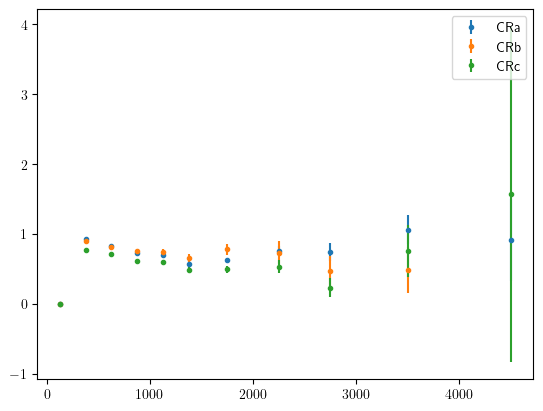

In [65]:
root_path = '/Users/diegomac/Documents/HEP/VBF-Analysis/Zll/Z-peak/'
path_CRa = root_path+"CRa"
path_CRb = root_path+"CRb"
path_CRc = root_path+"CRc"
signal = "Zll_MG"

histo={
"mass_jj":[[1500,3000],[250,500,1000],250],
}

CRa_axis,CRa_y,CRa_error=ratio_subtracted_plot(path_to_samples=path_CRa,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)
CRb_axis,CRb_y,CRb_error=ratio_subtracted_plot(path_to_samples=path_CRb,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)
CRc_axis,CRc_y,CRc_error=ratio_subtracted_plot(path_to_samples=path_CRc,signal_name=signal,data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)

plt.errorbar(CRa_axis,CRa_y,yerr=CRa_error,fmt='.')
plt.errorbar(CRb_axis,CRb_y,yerr=CRb_error,fmt='.')
plt.errorbar(CRc_axis,CRc_y,yerr=CRc_error,fmt='.')

plt.legend(['CRa','CRb','CRc'])

print(CRc_y[2])

In [66]:
CRa_axis

array([ 125.,  375.,  625.,  875., 1125., 1375., 1750., 2250., 2750.,
       3500., 4500.])

In [67]:
def parabolic_shape(mjj,a,b,c):
    return a*mjj*mjj+b*mjj+c


def chi_square2(model, slope, level,offset, x,y,uncer):
    chi=0
    for i in range(0,len(x)):
        chi+=((y[i]-model(x[i],slope,level,offset))**2)/(uncer[i]**2)
        #print(x[i])
        #print(((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2))
    return (chi/(len(x)-3))

CRa_fit, CRa_cov = curve_fit(parabolic_shape, CRa_axis[1:], CRa_y[1:],sigma=CRa_error[1:])
CRb_fit, CRb_cov = curve_fit(parabolic_shape, CRb_axis[1:], CRb_y[1:],sigma=CRb_error[1:])
CRc_fit, CRc_cov = curve_fit(parabolic_shape, CRc_axis[1:], CRc_y[1:],sigma=CRc_error[1:])
x = CRa_axis

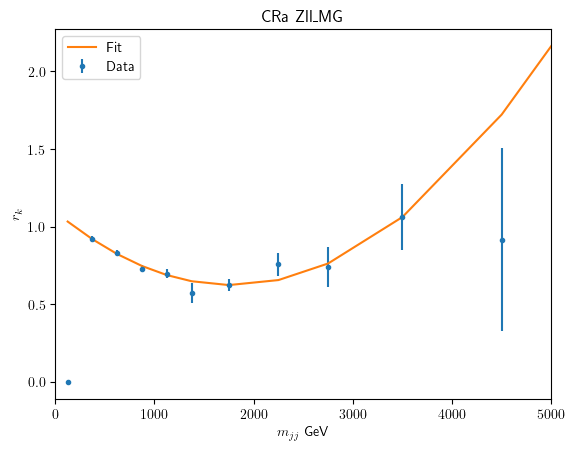

In [68]:
plt.errorbar(CRa_axis,CRa_y,yerr=CRa_error,fmt='.')
plt.rcParams['text.usetex'] = True
X = np.append(CRa_axis,5000.0)
plt.plot(X,parabolic_shape(X,CRa_fit[0],CRa_fit[1],CRa_fit[2]))
plt.legend(['Fit','Data'])
plt.xlabel(r'$m_{jj}$ GeV')
plt.ylabel(r'$r_{k}$')
plt.xlim(0,5000)
plt.title("CRa "+signal)
plt.savefig("CRa "+signal+'.pdf')

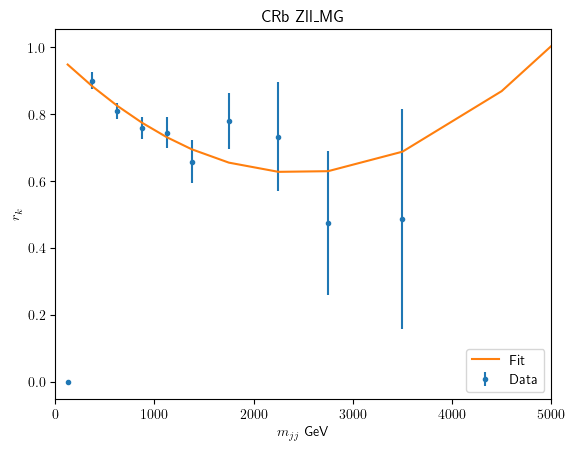

In [69]:
plt.errorbar(CRb_axis,CRb_y,yerr=CRb_error,fmt='.')
plt.plot(X,parabolic_shape(X,CRb_fit[0],CRb_fit[1],CRb_fit[2]))
plt.legend(['Fit','Data'])
plt.xlabel(r'$m_{jj}$ GeV')
plt.ylabel(r'$r_{k}$')
plt.xlim(0,5000)
plt.title("CRb "+signal)
plt.savefig("CRb "+signal+'.pdf')

0.713
0.7011565266297094


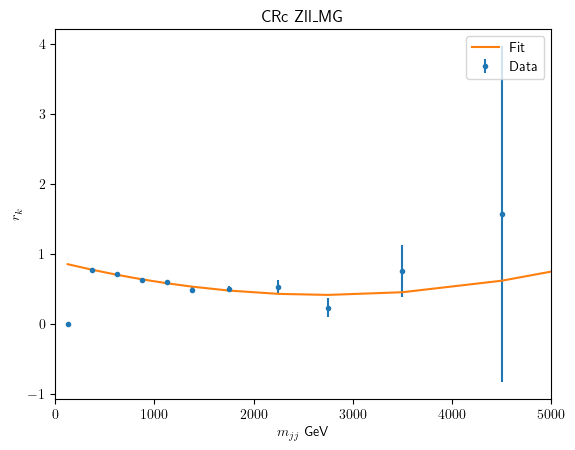

In [70]:
plt.errorbar(CRc_axis,CRc_y,yerr=CRc_error,fmt='.')
plt.plot(X,parabolic_shape(X,CRc_fit[0],CRc_fit[1],CRc_fit[2]))
plt.legend(['Fit','Data'])
plt.xlabel(r'$m_{jj}$ GeV')
plt.ylabel(r'$r_{k}$')
plt.xlim(0,5000)
plt.title("CRc "+signal)
plt.savefig("CRc "+signal+'.pdf')
print(CRc_y[2])
print(parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2])[2])

In [71]:
def model_uncern(covariance_matrix,x):
    sigma_a = covariance_matrix[0][0]
    sigma_b = covariance_matrix[1][1]
    sigma_c = covariance_matrix[2][2]
    
    cov_ab = covariance_matrix[0][1]
    cov_ac = covariance_matrix[0][2]
    cov_bc = covariance_matrix[1][2]
    
    diagonal_term = sigma_a*x**4 + sigma_b*x**2 + sigma_c
    no_diagonal_term = 2*cov_ab*x**3 + 2*cov_ac*x**2 + 2*cov_bc*x
    
    return np.sqrt(diagonal_term+no_diagonal_term)

model_uncer = np.vectorize(model_uncern)
#parabolic_shape = np.vectorize(parabolic_shape)

1.7206274085825612
0.4062509904950671


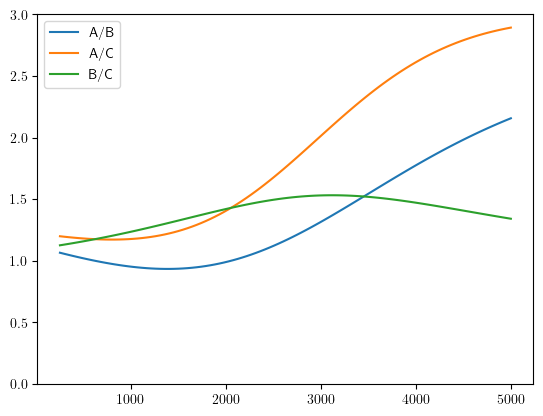

In [72]:
x=np.linspace(250,5000,100)

r_ab=parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2])/parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2])
r_ab_error=r_ab*np.sqrt((model_uncern(CRa_cov,x)/parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2]))**2
                        +(model_uncern(CRb_cov,x)/parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2])**2))

r_ac=parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2])/parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2])
r_ac_error=r_ac*np.sqrt((model_uncern(CRa_cov,x)/parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2]))**2
                        +(model_uncern(CRc_cov,x)/parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2])**2))

r_bc=parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2])/parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2])
r_bc_error=r_bc*np.sqrt((model_uncern(CRb_cov,x)/parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2]))**2
                        +(model_uncern(CRc_cov,x)/parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2])**2))



plt.plot(x,r_ab)
plt.plot(x,r_ac)
plt.plot(x,r_bc)
plt.legend(["A/B","A/C","B/C"])
plt.ylim(0,3)


print(r_ac.max()-r_ac.min())
print(r_bc.max()-r_bc.min())

In [73]:
x=CRa_axis
CRa_predy,CRa_prederror = parabolic_shape(x,CRa_fit[0],CRa_fit[1],CRa_fit[2]),model_uncern(CRa_cov,x)
CRb_predy,CRb_prederror = parabolic_shape(x,CRb_fit[0],CRb_fit[1],CRb_fit[2]),model_uncern(CRb_cov,x)
CRc_predy,CRc_prederror = parabolic_shape(x,CRc_fit[0],CRc_fit[1],CRc_fit[2]),model_uncern(CRc_cov,x)

SR_y = CRa_predy*CRc_predy/CRb_predy
SR_error = SR_y*np.sqrt((CRa_prederror/CRa_predy)**2+(CRb_prederror/CRb_predy)**2+(CRc_prederror/CRc_predy)**2)

SF =  [0.9305098524659373, 0.8055022509871163, 0.7005138456575858, 0.6148471799390771, 0.5476637233703608, 0.4980214187295405, 0.45433040591810847, 0.44928495013470376, 0.5025469380500622, 0.699682605985574, 1.22382420154473]
SF error =  [0.04832890534667152, 0.02574072729127268, 0.016846329390897207, 0.019716672699407897, 0.02444845981838134, 0.028503895370850834, 0.03737669148607362, 0.0691478179258792, 0.1393170662814514, 0.35233587557526386, 0.9144863451915262]
[ 125.  375.  625.  875. 1125. 1375. 1750. 2250. 2750. 3500. 4500.]


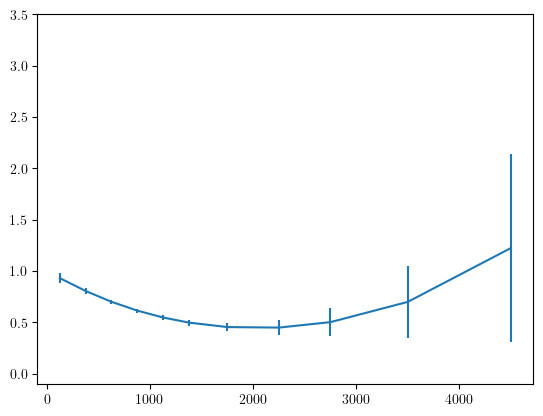

In [74]:
plt.errorbar(x,SR_y,yerr=SR_error)
plt.ylim([-.1,3.5])

print("SF = ",list(SR_y))
print("SF error = ",list(SR_error))
print(x)

In [75]:
def parabolic_shape(mjj,a,b,c):
    return a*mjj*mjj+b*mjj+c
SR_fit, SR_cov = curve_fit(parabolic_shape, x, SR_y,sigma=SR_error)

def fit_results(params,covariance,params_names):
    result = []
    for i in range(0,len(params)):
        result.append(params[i])
        result.append(np.sqrt(covariance[i][i]))
        
    column_name = []
    for i in params_names:
        column_name.append(i)
        column_name.append('Sigma '+i)
        
    df = pd.DataFrame (result,index=column_name)
    return df.T
print("Parameters ",SR_fit)
print("Covariance Matrix",SR_cov)
fit_results(CRb_fit,CRb_cov,['a','b','c'])


Parameters  [ 1.35194976e-07 -5.44814676e-04  9.89623845e-01]
Covariance Matrix [[ 6.10103780e-18 -1.39152060e-14  6.28353596e-12]
 [-1.39152060e-14  3.55524558e-11 -1.77055100e-08]
 [ 6.28353596e-12 -1.77055100e-08  1.02381776e-05]]


,a,Sigma a,b,Sigma b,c,Sigma c
0,5.894448e-08,3.647768e-08,-0.000291,0.00009,0.983461,0.045074


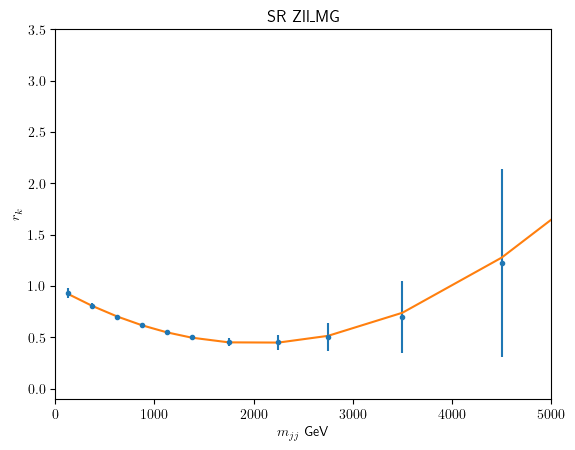

In [76]:
plt.errorbar(x,SR_y,yerr=SR_error,fmt='.')
plt.ylim([-.1,3.5])
plt.plot(X,parabolic_shape(X,SR_fit[0],SR_fit[1],SR_fit[2]))
plt.xlabel(r'$m_{jj}$ GeV')
plt.ylabel(r'$r_{k}$')
plt.xlim(0,5000)
plt.title("SR "+signal)
plt.savefig("SR "+signal+'.pdf')

In [40]:
path="../Zll/"
qcd_sample="Zll_Sherpa.root"
vbf_sample="Signal_Sherpa.root"

histo={
"mass_jj":[[1500,3000],[250,500,1000],250],
}

regions=["CRa/","CRb/","CRc/"]
colors=[r.kRed,r.kGreen,r.kBlue]#[["CRb/","CRa/"],["CRb/","CRc/"]]#

r.TH1.AddDirectory(r.kFALSE)
Canvas = ROOT.TCanvas("canvas")
Canvas.cd()

legend = ROOT . TLegend (0.20 ,0.75 ,0.40 ,0.85)

c=0
output_file = r.TFile.Open("Output.root","RECREATE")
for cr in regions:
    CR_file=r.TFile.Open(path+cr+qcd_sample)
    SR_file=r.TFile.Open(path+"SR/"+qcd_sample)
    
    CR_file_data=r.TFile.Open(path+cr+"Data.root")
    SR_file_data=r.TFile.Open(path+"SR/"+"Data.root")
    
    CR_file_signal=r.TFile.Open(path+cr+vbf_sample)
    SR_file_signal=r.TFile.Open(path+"SR/"+vbf_sample)
    
    CR=CR_file.Get("mass_jj")
    SR=SR_file.Get("mass_jj")
    
    CR_data=CR_file_data.Get("mass_jj")
    SR_data=SR_file_data.Get("mass_jj")
    
    CR_signal=CR_file_signal.Get("mass_jj")
    SR_signal=SR_file_signal.Get("mass_jj")
    
    CR_data.Add(CR_signal,-1)
    SR_data.Add(SR_signal,-1)
    
    rebining=biner(histo["mass_jj"][0],histo["mass_jj"][1],SR)
    nb=len(rebining)-1

    CR=CR.Rebin(nb,"CR",rebining)
    SR=SR.Rebin(nb,"SR",rebining)
    
    CR_data=CR_data.Rebin(nb,"CR",rebining)
    SR_data=SR_data.Rebin(nb,"SR",rebining)

    CR_data.Scale(1/CR_data.Integral(1,-1,"width"))
    SR_data.Scale(1/SR_data.Integral(1,-1,"width"))

    CR.Scale(1/CR.Integral(1,-1,"width"))
    SR.Scale(1/SR.Integral(1,-1,"width"))
    
    CR_data.Divide(CR)
    SR_data.Divide(SR)
    
    SR.Divide(CR)
    SR.SetTitle("SR/CRi")
    SR.SetLineColor(colors[c])
    
    
    print(Unpack_Histo(CR_data))
    r.gStyle.SetOptStat(0)
    
    
    
    c+=1
    SR.GetYaxis().SetRangeUser(0,3)
    
    #legend.AddEntry(SR,cr[1][:-1]+"/"+cr[0][:-1])
    legend.AddEntry(SR,"SR/"+cr[:-1])
    
    CR_data.Draw("same")
    SR.GetYaxis().SetRangeUser(0.1,50)
    SR.GetXaxis().SetTitle("m_{jj}")

    output_file.WriteObject(CR_data,cr)
    
legend.Draw()
Canvas.SetLogy(1)
output_file.Close()
Canvas.Print("Zll_CRi-SR.pdf") 
    
    

NameError: name 'r' is not defined

# CRi/CRj MC plots

In [ ]:
path="../Zll/"
qcd_sample="Zll_MG.root"
vbf_sample="Signal_Sherpa.root"

histo={
"mass_jj":[[1500,3000],[250,500,1000],250],
}

regions = [["CRa/","CRb/"],["CRc/","CRb/"]]
colors=[r.kBlue,r.kRed]

r.TH1.AddDirectory(r.kFALSE)
Canvas = ROOT.TCanvas("canvas")
Canvas.cd()

legend = ROOT . TLegend (0.20 ,0.75 ,0.40 ,0.85)

c=0
output_file = r.TFile.Open("Output.root","RECREATE")
for cr in regions:
    CRi_file=r.TFile.Open(path+cr[0]+qcd_sample)
    CRj_file=r.TFile.Open(path+cr[1]+qcd_sample)
    
    CRi=CRi_file.Get("mass_jj")
    CRj=CRj_file.Get("mass_jj")
    
    rebining=biner(histo["mass_jj"][0],histo["mass_jj"][1],CRi)
    nb=len(rebining)-1

    CRi=CRi.Rebin(nb,"CR",rebining)
    CRj=CRj.Rebin(nb,"CR",rebining)

    CRi.Scale(1/CRi.Integral(1,-1,"width"))
    CRj.Scale(1/CRj.Integral(1,-1,"width"))

    CRi.Divide(CRj)
    CRi.SetTitle("CRi/CRj")
    CRi.SetLineColor(colors[c])
    
    print(Unpack_Histo(CRi))
    r.gStyle.SetOptStat(0)
    
    c+=1
    CRi.GetYaxis().SetRangeUser(0,3)
    
    legend.AddEntry(CRi,cr[0][:-1]+"/"+cr[1][:-1])

    
    CRi.Draw("same")
    CRi.GetYaxis().SetRangeUser(0.1,50)
    CRi.GetXaxis().SetTitle("m_{jj}")

    output_file.WriteObject(CRi,cr[0])
    
legend.Draw()
Canvas.SetLogy(1)
output_file.Close()
Canvas.Print("Zll_CRi-CRj.pdf") 

In [ ]:
# DATA/MC (CRa)
datamc_mg = np.array([1.17287099, 1.05095482, 0.92308652, 0.87660265, 0.71172017, 0.79195541, 0.93657303, 0.94271851, 1.36295712, 1.19747162])
datamc_sherpa = np.array([1.21873772, 1.10637128, 1.01299345, 0.92340606, 0.79855639, 0.74728167, 0.79572594, 0.4959183 , 0.57277864, 0.38938245])
datamc_mg_err = np.array([0.02628175, 0.02390504, 0.02850612, 0.03746677, 0.07936187,0.04879905, 0.09014562, 0.16244972, 0.27015595, 0.75309312])
datamc_sherpa_err = np.array([0.02664247, 0.02801487, 0.03076661, 0.03707245, 0.04408269, 0.04624233, 0.06874639, 0.08017466, 0.12399572, 0.20784691])

# MC/MC (CRc/CRb)
mcmc_mg = np.array([1.25653172, 0.95911849, 0.83627921, 0.76530528, 0.70465183, 0.76431251, 0.67780083, 0.43664312, 0.45886752, 0.62432247])
mcmc_sherpa = np.array([1.23392093, 1.03752315, 0.8849799 , 0.75316083, 0.67003554, 0.67421633, 0.56153172, 0.49623686, 0.39219835, 0.45996645])
mcmc_mg_err = np.array([0.02292674, 0.01761642, 0.02137271, 0.0281082 , 0.0448343 , 0.04852067, 0.09465751, 0.12061694, 0.13820855, 0.39303658])
mcmc_sherpa_err = np.array([0.02263625, 0.01581388, 0.01810401, 0.0234124 , 0.02358959, 0.02246332, 0.03077217, 0.04067631, 0.0854782 , 0.0702685 ])

# Scale factors
scaling_factors_mg = datamc_mg/mcmc_mg
mg_err = (datamc_mg/mcmc_mg)*((datamc_mg_err/datamc_mg)**2+(mcmc_mg_err/mcmc_mg)**2)**0.5
scaling_factors_sherpa = datamc_sherpa/mcmc_sherpa
sherpa_err = (datamc_sherpa/mcmc_sherpa)*((datamc_sherpa_err/datamc_sherpa)**2+(mcmc_sherpa_err/mcmc_sherpa)**2)**0.5

scaling_factors_average = (scaling_factors_sherpa/sherpa_err**2+scaling_factors_mg/mg_err**2)/(1/sherpa_err**2+1/mg_err**2)


In [ ]:
def fillHistogram(histogram,entries,errors):
    for i in range(1,len(entries)+1):
        histogram.SetBinContent(i,entries[i-1])
        histogram.SetBinError(i,errors[i-1])


file = r.TFile.Open("Output.root","RECREATE")
histogram_mg = r.TH1D("MGsf","Madgraph RW Factors",5000,0.0,5000.0)
histogram_sherpa = r.TH1D("Sherpasf","Sherpa RW Factors",5000,0.0,5000.0)
histogram_mg=histogram_mg.Rebin(nb,"MadGraph RW Factors",rebining)
histogram_sherpa=histogram_sherpa.Rebin(nb,"Sherpa RW Factors",rebining)

fillHistogram(histogram_mg,)

file.WriteObject(histogram_mg,"MadgraphSF")
file.WriteObject(histogram_sherpa,"SherpaSF")

file.Close()

In [ ]:
len(scaling_factors_mg)